# What is good food?

## 📖 Background
You and your friend have gotten into a debate about nutrition. Your friend follows a high-protein diet and does not eat any carbohydrates (no grains, no fruits). You claim that a balanced diet should contain all nutrients but should be low in calories. Both of you quickly realize that most of what you know about nutrition comes from mainstream and social media.

Being the data scientist that you are, you offer to look at the data yourself to answer a few key questions.

## 💾 The data

You source nutrition data from USDA's FoodData Central [website](https://fdc.nal.usda.gov/download-datasets.html). This data contains the calorie content of 7,793 common foods, as well as their nutritional composition. Each row represents one food item, and nutritional values are based on a 100g serving. Here is a description of the columns:

- **FDC_ID**: A unique identifier for each food item in the database.
- **Item**: The name or description of the food product.
- **Category**: The category or classification of the food item, such as "Baked Products" or "Vegetables and Vegetable Products".
- **Calories**: The energy content of the food, presented in kilocalories (kcal).
- **Protein**: The protein content of the food, measured in grams.
- **Carbohydrate**: The carbohydrate content of the food, measured in grams.
- **Total fat**: The total fat content of the food, measured in grams.
- **Cholesterol**: The cholesterol content of the food, measured in milligrams.
- **Fiber**: The dietary fiber content of the food, measured in grams.
- **Water**: The water content of the food, measured in grams.
- **Alcohol**: The alcohol content of the food (if any), measured in grams.
- **Vitamin C**: The Vitamin C content of the food, measured in milligrams.

## 💪 Competition challenge

Create a report that covers the following:

1. Which fruit has the highest vitamin C content? What are some other sources of vitamin C?
2. Describe the relationship between the calories and water content of a food item.
3. What are the possible drawbacks of a zero-carb diet? What could be the drawbacks of a very high-protein diet?
4. According to the Cleveland Clinic [website](https://my.clevelandclinic.org/health/articles/4182-fat-and-calories), a gram of fat has around 9 kilocalories, and a gram of protein and a gram of carbohydrate contain 4 kilocalories each. Fit a linear model to test whether these estimates agree with the data.
5. Analyze the errors of your linear model to see what could be the hidden sources of calories in food.

# Data Cleaning and Munging

Openning the .csv file and assigning it to `food` variable. This will be the complete data frame over which we will operate with the goal to achieve all the expectations

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

food = pd.read_csv('nutrition.csv',
                   na_values='null')
food.head()

FDC_ID                                               Item  ... Alcohol Vitamin C
0  167512  Pillsbury Golden Layer Buttermilk Biscuits, Ar...  ...     NaN       NaN
1  167513  Pillsbury, Cinnamon Rolls with Icing, refriger...  ...     NaN    0.1 mg
2  167514  Kraft Foods, Shake N Bake Original Recipe, Coa...  ...     NaN       NaN
3  167515     George Weston Bakeries, Thomas English Muffins  ...     NaN       NaN
4  167516         Waffles, buttermilk, frozen, ready-to-heat  ...   0.0 g    0.0 mg

[5 rows x 12 columns]

Converting the variables names to python's pattern (snake case) to ease the treatment and maintain the pattern from the language

In [374]:
food.columns = (food
                .columns
                .str.replace(' ','_')
                .str.lower())
food.columns

Index(['fdc_id', 'item', 'category', 'calories', 'protein', 'carbohydrate',
       'total_fat', 'cholesterol', 'fiber', 'water', 'alcohol', 'vitamin_c'],
      dtype='object')

First, let's take a look on how the data are distributed along the data frame checking for missing values, as well as the data types of each column

In [375]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793 entries, 0 to 7792
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   fdc_id        7793 non-null   int64 
 1   item          7793 non-null   object
 2   category      7793 non-null   object
 3   calories      7793 non-null   object
 4   protein       7793 non-null   object
 5   carbohydrate  7793 non-null   object
 6   total_fat     7793 non-null   object
 7   cholesterol   7394 non-null   object
 8   fiber         7231 non-null   object
 9   water         7793 non-null   object
 10  alcohol       5399 non-null   object
 11  vitamin_c     7332 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.7+ KB


One may observe that most columns are object-types. For numerical columns of type continuous as `'calories'`, `'protein'`, `'carbohydrate'`, `'total_fat'`,`'cholesterol'`, `'fiber'`, `'water'`, `'alcohol'` and `'vitamin_c' `we shall convert them on np.float64.

To do that we may remove the units associated with the numerical values allowing then to operate and manipulate them as numerical variables

In [376]:
food['calories'] = (food['calories']
                    .str.extract(r'(\d+\.\d+)')
                    .astype(np.float64))

food['total_fat'] = (food['total_fat']
                          .str.extract(r'(\d+\.\d+)')
                          .astype(np.float64))

food['cholesterol'] = (food['cholesterol']
                       .str.extract(r'(\d+\.\d+)')
                       .astype(np.float64))

food['fiber'] = (food['fiber']
                 .str.extract(r'(\d+\.\d+)')
                 .astype(np.float64))

food['water'] = (food['water']
                 .str.extract(r'(\d+\.\d+)')
                 .astype(np.float64))

food['alcohol'] = (food['alcohol']
                   .str.extract(r'(\d+\.\d+)')
                   .astype(np.float64))

food['vitamin_c'] = (food['vitamin_c']
                     .str.extract(r'(\d+\.\d+)')
                     .astype(np.float64))

food['carbohydrate'] = (food['carbohydrate']
                        .str.extract(r'(\d+\.\d+)')
                        .astype(np.float64))

food['protein'] = (food['protein']
                   .str.extract(r'(\d+\.\d+)')
                   .astype(np.float64))

Converting the `cholesterol` and `vitamin_c` features from miligrams to grams in order to make all info in the data frame be the same

In [377]:
food['cholesterol'] = (food['cholesterol'] * 0.001).round(3)
food['vitamin_c'] = (food['vitamin_c'] * 0.001).round(3)

Once `fdc_id`, `category` and `item` describes each food product, in order to optimize the data processing its type will be set to 'category'

In [378]:
food['fdc_id'] = pd.Categorical(food['fdc_id'])
food['category'] = pd.Categorical(food['category'])
food['item'] = pd.Categorical(food['item'])

Visualizing the missing values as bar plots for more intuitive understanding on how I can clean and deal with the data

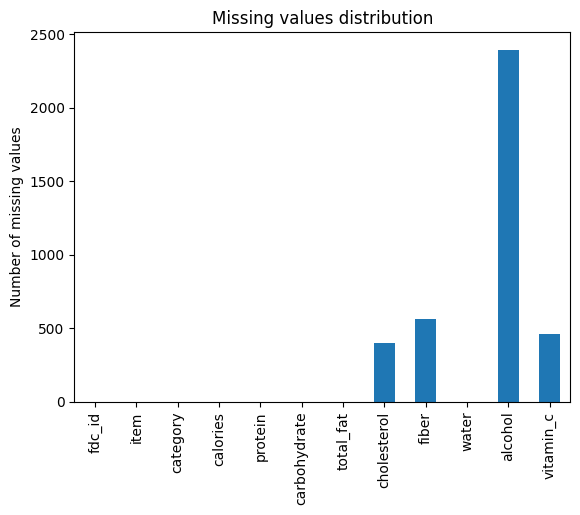

In [379]:
(food
 .isna()
 .sum()
 .plot(kind='bar'))
plt.ylabel('Number of missing values')
plt.title('Missing values distribution')
plt.show()

Avaluating in percentage how many missing values that exists for the features `cholesterol`, `fiber`, `alcohol` and `vitamin_c`

In [380]:
cholesterol = (food
               .loc[:,'cholesterol']
               .isna()
               .value_counts(normalize=True)[1] # selects only the percentage of NaN values
               .round(3))

fiber = (food
         .loc[:,'fiber']
         .isna()
         .value_counts(normalize=True)[1] # selects only the percentage of NaN values
         .round(3))

alcohol = (food['alcohol']
           .isna()
           .value_counts(normalize=True)[1] # selects only the percentage of NaN values
           .round(3))

vitamin_c = (food['vitamin_c']
             .isna()
             .value_counts(normalize=True)[1] # selects only the percentage of NaN values
             .round(3))

nan_values = (pd.DataFrame([cholesterol,fiber,alcohol,vitamin_c],
                          index=['cholesterol','fiber','alcohol','vitamin_c'])
              .rename(columns={0:'missing_values'}))
nan_values

missing_values
cholesterol           0.051
fiber                 0.072
alcohol               0.307
vitamin_c             0.059

Once for `cholesterol`, `fiber`, `vitamin_c` has less than 10% of missing values, deleting those will cause little or none impact on future analysis 

In [381]:
food.dropna(subset=['cholesterol','fiber','vitamin_c'],
            how='any',
            inplace=True)
food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6846 entries, 1 to 7792
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   fdc_id        6846 non-null   category
 1   item          6846 non-null   category
 2   category      6846 non-null   category
 3   calories      6846 non-null   float64 
 4   protein       6846 non-null   float64 
 5   carbohydrate  6846 non-null   float64 
 6   total_fat     6846 non-null   float64 
 7   cholesterol   6846 non-null   float64 
 8   fiber         6846 non-null   float64 
 9   water         6846 non-null   float64 
 10  alcohol       5331 non-null   float64 
 11  vitamin_c     6846 non-null   float64 
dtypes: category(3), float64(9)
memory usage: 1.2 MB


`alcohol` has 31% of missing values thus, its missing values will be filled with statistics metrics according to how it is distributed the data

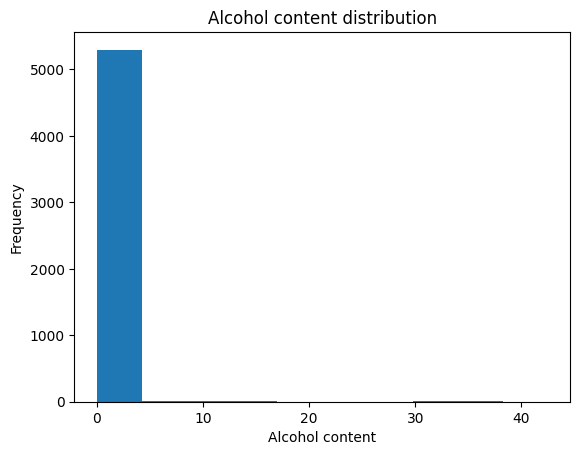

In [382]:
food['alcohol'].plot(kind='hist')
plt.xlabel('Alcohol content')
plt.title('Alcohol content distribution')
plt.show()

In [383]:
(food
 .loc[:,'alcohol']
 .value_counts(normalize=True)
 .head())

0.0     0.992122
33.4    0.000563
3.3     0.000375
15.3    0.000375
0.3     0.000375
Name: alcohol, dtype: float64

Observing the `alcohol`'s histogram plot and together the distibution of the data one may see that 99.21% of its values is 0.0, so the most adequated statistics measure to adopt for filling missing values is the median which has the value of 0.0

In [384]:
food['alcohol'].fillna(0.0,
                      inplace=True)

In [385]:
food.head()

fdc_id  ... vitamin_c
1  167513  ...       0.0
4  167516  ...       0.0
5  167517  ...       0.0
6  167518  ...       0.0
8  167520  ...       0.0

[5 rows x 12 columns]

Rechecking the data types if were changed and the missing data filled or deleted accordingly to expected

In [386]:
food.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6846 entries, 1 to 7792
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   fdc_id        6846 non-null   category
 1   item          6846 non-null   category
 2   category      6846 non-null   category
 3   calories      6846 non-null   float64 
 4   protein       6846 non-null   float64 
 5   carbohydrate  6846 non-null   float64 
 6   total_fat     6846 non-null   float64 
 7   cholesterol   6846 non-null   float64 
 8   fiber         6846 non-null   float64 
 9   water         6846 non-null   float64 
 10  alcohol       6846 non-null   float64 
 11  vitamin_c     6846 non-null   float64 
dtypes: category(3), float64(9)
memory usage: 1.2 MB


Using DataViz in order to visualize the absence of missing data

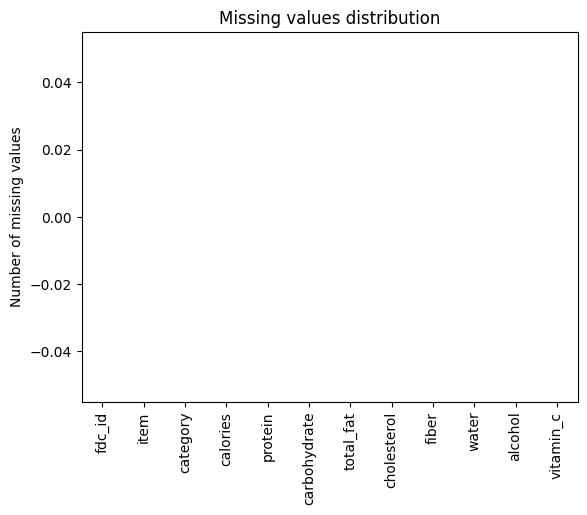

In [387]:
(food
 .isna()
 .sum()
 .plot(kind='bar'))
plt.ylabel('Number of missing values')
plt.title('Missing values distribution')
plt.show()

Now we may assess the descriptive statistics of the cleaned data frame

In [388]:
food.describe()

calories      protein  ...      alcohol    vitamin_c
count  6846.000000  6846.000000  ...  6846.000000  6846.000000
mean    220.845457    12.299255  ...     0.102249     0.008591
std     168.212364    10.943843  ...     1.629443     0.069884
min       0.000000     0.000000  ...     0.000000     0.000000
25%      94.000000     2.350000  ...     0.000000     0.000000
50%     184.500000     9.580000  ...     0.000000     0.000000
75%     315.000000    21.290000  ...     0.000000     0.003000
max     902.000000    88.320000  ...    42.500000     2.732000

[8 rows x 9 columns]

After all these manipulations on the data frame we may now start to answer some questions

# Answering the questions

## 1) Which fruit has the most Vitamin C content?

Checking the categories of all possible food products as well as how many observations do they compose of the data frame

We may see that the most food products on the given data set are beef products

In [389]:
food['category'].value_counts()

Beef Products                          954
Vegetables and Vegetable Products      715
Baked Products                         403
Lamb, Veal, and Game Products          396
Poultry Products                       368
Sweets                                 350
Pork Products                          328
Baby Foods                             310
Beverages                              304
Fruits and Fruit Juices                297
Dairy and Egg Products                 284
Finfish and Shellfish Products         255
Legumes and Legume Products            251
Fast Foods                             251
Soups, Sauces, and Gravies             218
Fats and Oils                          200
Breakfast Cereals                      187
Sausages and Luncheon Meats            163
Snacks                                 158
Cereal Grains and Pasta                143
Nut and Seed Products                  100
Meals, Entrees, and Side Dishes         67
Spices and Herbs                        61
Restaurant 

Analyzing the `'item'` feature on `food` data frame one may observe that the main ingredient comes first followed by the others. In order to select only the most present ingredient a new feature will be created using regex and its name will be `'main_ingredient'`

In [390]:
food['main_ingredient'] = (food.loc[:,'item']
                           .str.extract(r'(.+?)(?:,|\s)'))
food['main_ingredient'] = pd.Categorical(food['main_ingredient'])
food.head()

fdc_id  ... main_ingredient
1  167513  ...       Pillsbury
4  167516  ...         Waffles
5  167517  ...          Waffle
6  167518  ...          Waffle
8  167520  ...             Pie

[5 rows x 13 columns]

Subsetting in order to obtain only the observations that are fruit-based and assigning it to a new data frame called `fruits`

In [391]:
fruits = food.loc[food['category'] == 'Fruits and Fruit Juices']
fruits.head()

fdc_id  ... main_ingredient
4992  167746  ...          Lemons
4993  167747  ...           Lemon
4994  167748  ...           Lemon
4995  167749  ...           Lemon
4996  167750  ...         Prickly

[5 rows x 13 columns]

Dropping duplicated values from `fruits` in order to have only the maximum value of `vitamin_c` for each fruit

In [392]:
fruits = (fruits
          .sort_values('main_ingredient',
                       ascending=False)
          .drop_duplicates('main_ingredient',
                          keep='first'))
print(fruits.shape)
fruits

(95, 13)


fdc_id  ... main_ingredient
5011  167765  ...      Watermelon
5144  169105  ...      Tangerines
5192  169925  ...       Tangerine
5009  167763  ...       Tamarinds
5032  167786  ...        Tamarind
...      ...  ...             ...
5238  171704  ...         Apricot
5230  171696  ...      Applesauce
5223  171689  ...          Apples
5046  167800  ...           Apple
5221  171687  ...         Acerola

[95 rows x 13 columns]

Others fruits that contains vitamin c are the following for example

In [393]:
np.random.seed(42) # guaranteeing the reproductibility of the output
vitamin_c_items = (fruits
                   .loc[:,['main_ingredient','vitamin_c']]
                   .sample(10))
vitamin_c_items

main_ingredient  vitamin_c
5263            Figs      0.001
5171           Plums      0.000
5260           Dates      0.000
5259   Custard-apple      0.019
5011      Watermelon      0.008
5206           Pears      0.001
5179           Melon      0.006
5129      Mangosteen      0.003
5051            Ruby      0.049
5176     Mammy-apple      0.014

Catching the richest fruit in vitamin c

In [394]:
vitamin_c_richest = (fruits
                     .loc[:,'vitamin_c']
                     .idxmax()) # produces the index label of the maximum value on vitamin_c feature
most_vitamin_c = fruits.loc[vitamin_c_richest]
most_vitamin_c['main_ingredient']

'Acerola'

**Therefore, with all the information above extracted we may conclude that the fruit with the most quantity of Vitamin C is 'Acerola'**

## 2) Assessing the relationship between water content and calories quantity

In order to describe the relationship between the water content (in grams) and the calories (in kcal) quantity we may subset the dataframe `food` to have only the `water` and `calories` variables and assign that data frame to `water_x_cal`

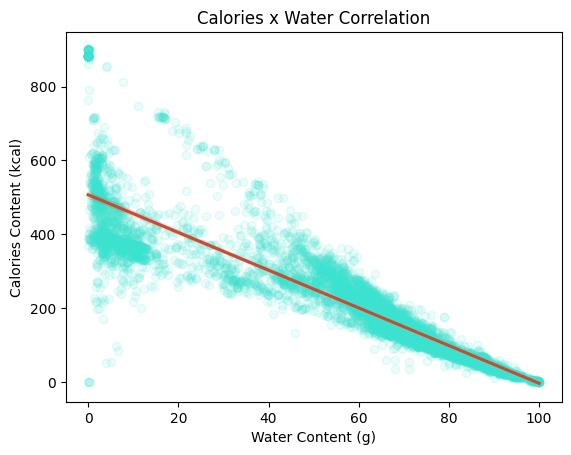

In [395]:
water_x_cal = food.loc[:,['water','calories']]
sns.regplot(data=water_x_cal,
            x='water',
            y='calories',
            scatter_kws=dict(color='#3ce2d0',
                             alpha=0.1),
            line_kws=dict(color='#ca4b2f'),
            ci=100)
plt.title('Calories x Water Correlation')
plt.ylabel('Calories Content (kcal)')
plt.xlabel('Water Content (g)')
plt.show()

Observing the behavior of the plot and its similarity with a straight line, one may conclude that there is a negative linear correlation between the variable. Let's measure and determine quantitatively how much is that negative correlation

In [396]:
water_and_cal_corrcoef = np.corrcoef([water_x_cal['water'],
                                      water_x_cal['calories']])
water_and_cal_corrcoef[0,1] # selecting the value from the correlation matrix that is assigned to the                                       # relationship between the two variables

-0.8923978354759373

With the values and the graphical visualization combined we may conclude that there is an intense negative correlation (once the **correlation coefficient is nearly -0.9**) between the water content in grams and the calories quantity

**Those conclusions allow to observe that the greater the water content, the lesser is the calories present on the food and vice-versa**

## 3) Types of diets: zero carbohydrates and high protein consequences

### 3.1) Dealing with the zero-carb diet

First, let's subset the data frame for all items which have zero carbohydrate content

In [397]:
zero_carb = food[food['carbohydrate'] == 0]
zero_carb.head()

fdc_id  ... main_ingredient
472   175040  ...       Leavening
551   167961  ...          Snacks
910   169599  ...        Gelatins
1865  167607  ...           Moose
1897  167639  ...            Fish

[5 rows x 13 columns]

In [398]:
zero_carb.shape

(1987, 13)

Now let's assess how the data's feature are distributed in order to choose the best central tendency measure to use in order to analyze the composition of a zero carb diet

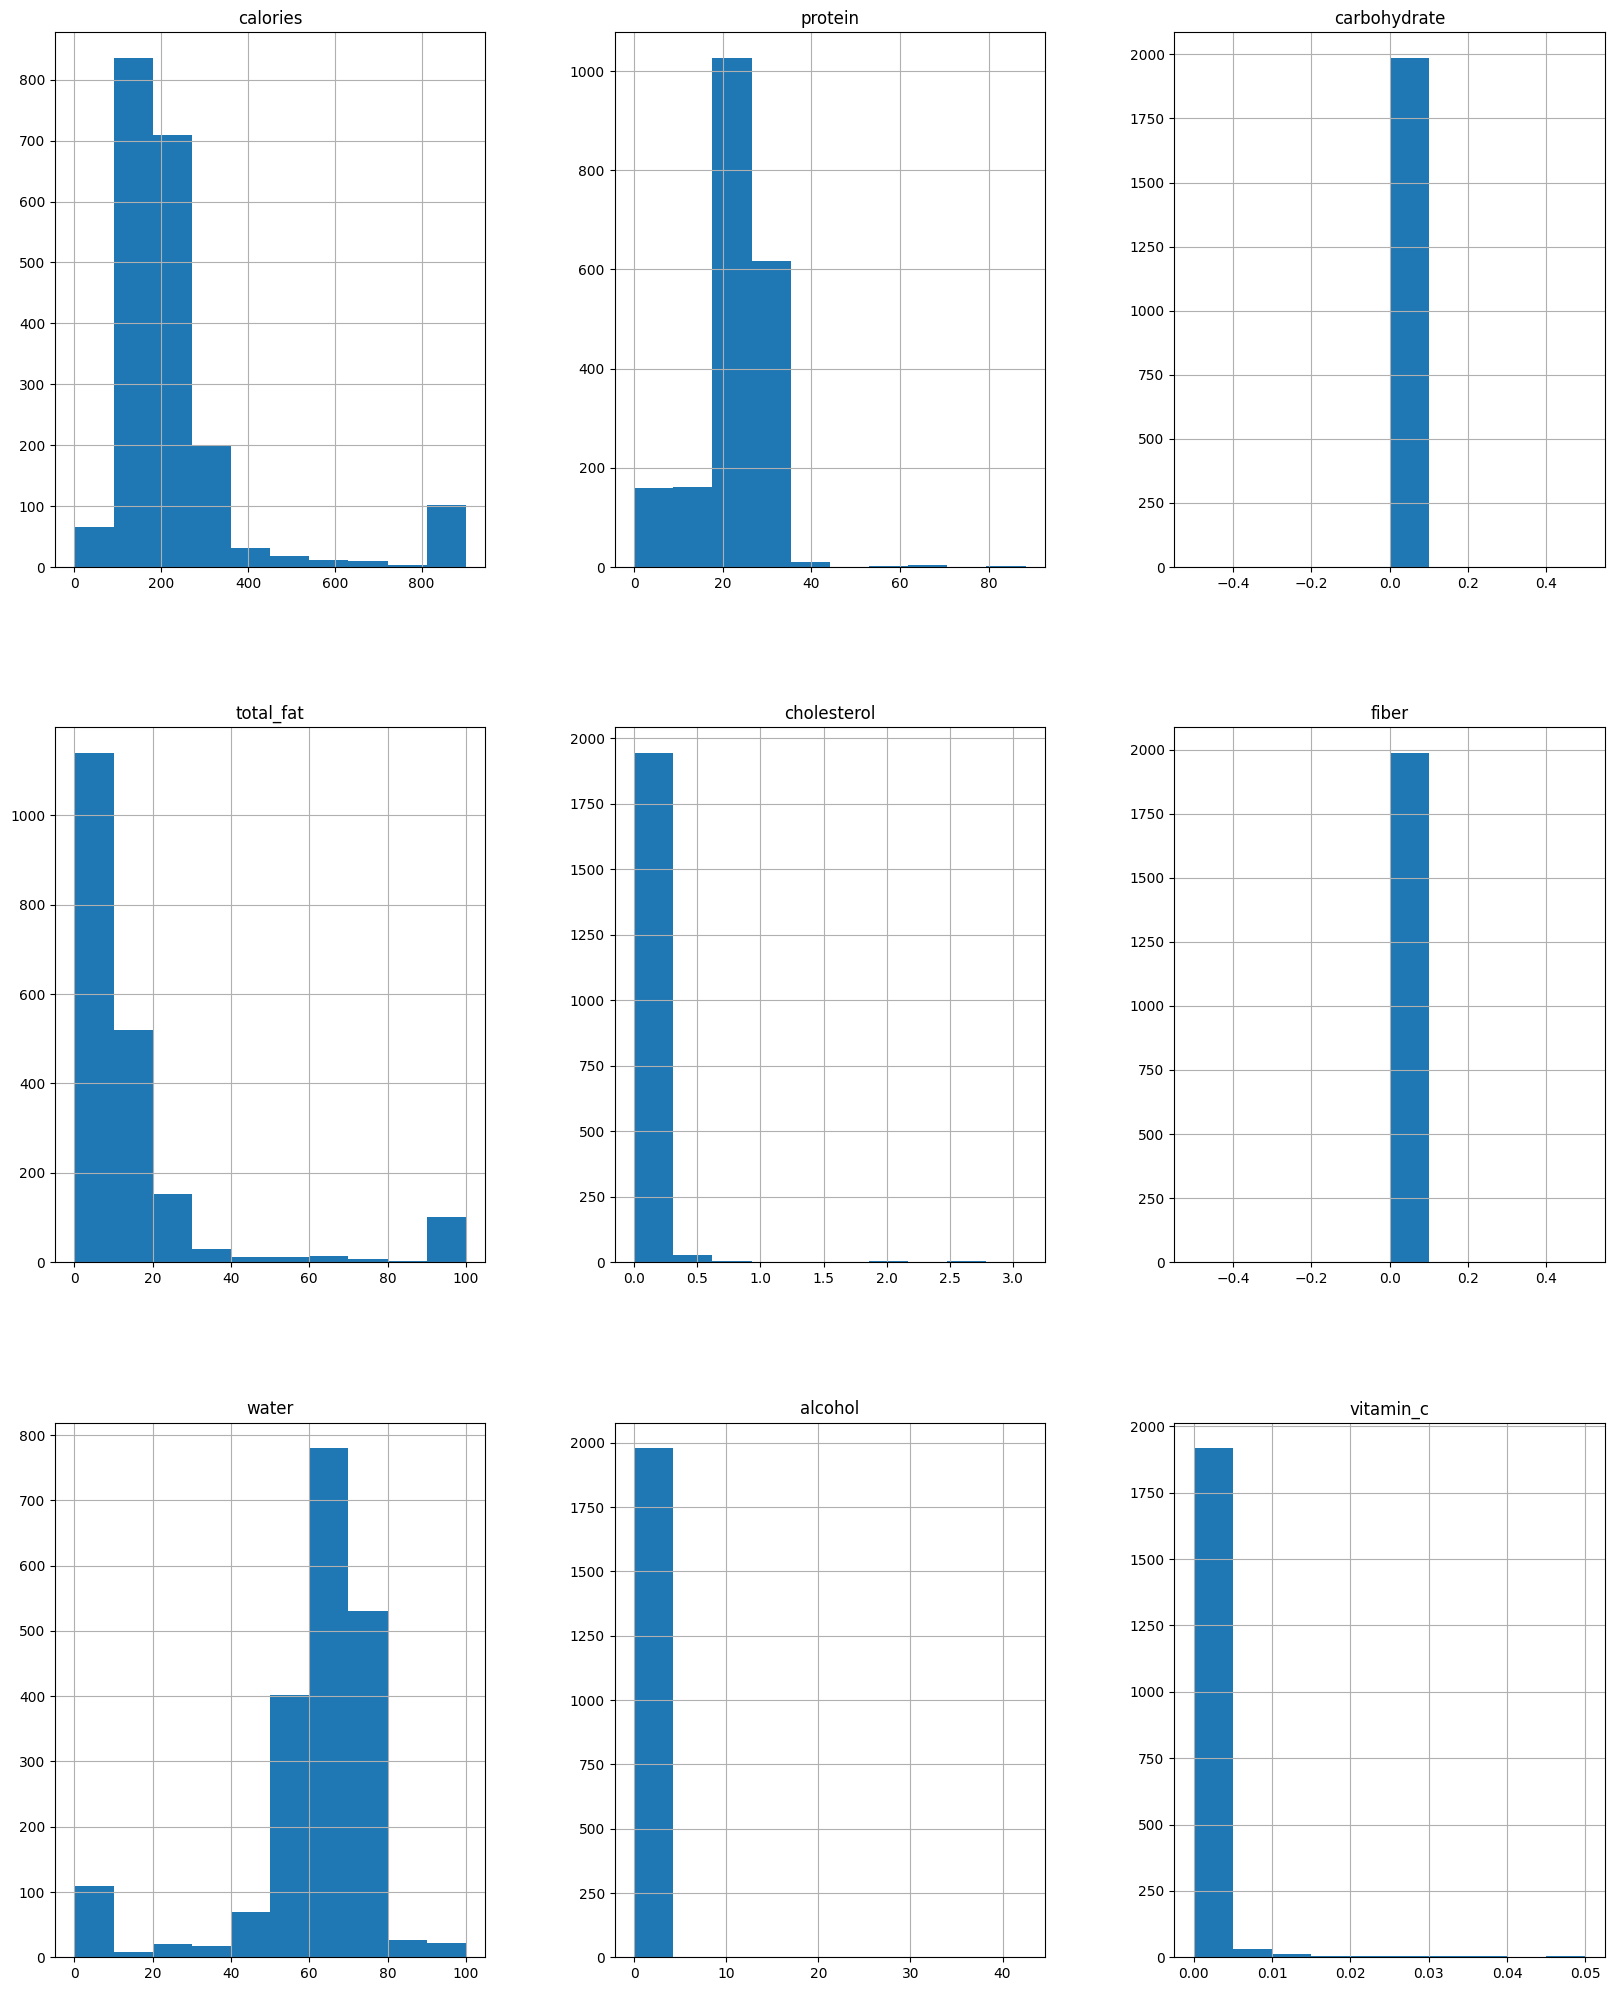

In [399]:
zero_carb.hist(figsize=(20,25))
plt.show()

As shown above, majorly all non-null features have a significant number of outliers (may impacting the mean) and some skewness, being the later positive or negative. Hence, the median will be selected as measure of central tendency.

Calculating the median for each feature we get the following results

In [400]:
zero_carb_median = zero_carb.median()
zero_carb_median

calories        190.000
protein          23.280
carbohydrate      0.000
total_fat         8.410
cholesterol       0.078
fiber             0.000
water            64.390
alcohol           0.000
vitamin_c         0.000
dtype: float64

To assess on how is the diet composition let's plot a pie chart and see the percentage of each non-null macronutrient on the diet

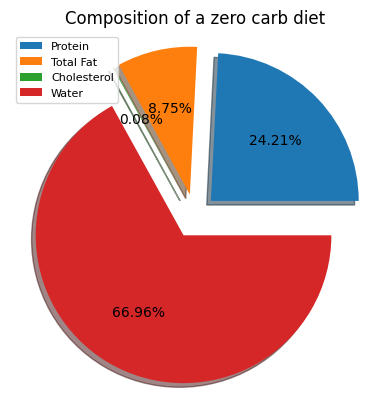

In [401]:
(zero_carb_median[['protein','total_fat','cholesterol','water']]
 .plot(kind='pie',
       autopct='%.2f%%',
       explode=[0.15]*4,
       labels=None,
       shadow=True))

plt.legend(['Protein','Total Fat','Cholesterol','Water'],
          fontsize=8,
          loc='upper left')

plt.title('Composition of a zero carb diet')
plt.show()

Focusing in the calories content and putting in evidence its distribution shape as well to observe for potential outliers a boxplot and a histogram were plotted

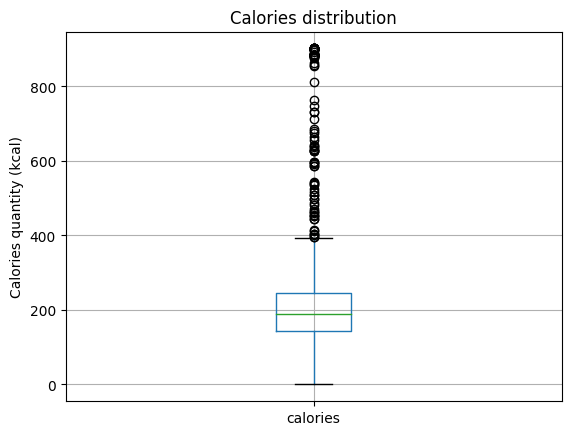

In [402]:
zero_carb.boxplot('calories')
plt.ylabel('Calories quantity (kcal)')
plt.title('Calories distribution')
plt.show()

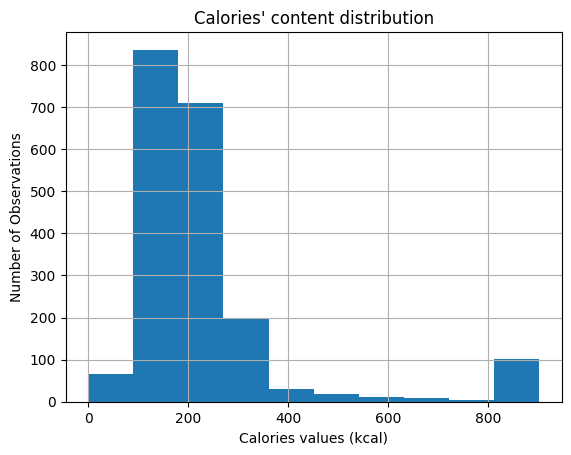

In [403]:
zero_carb.calories.hist()
plt.ylabel('Number of Observations')
plt.xlabel('Calories values (kcal)')
plt.title('Calories\' content distribution')
plt.show()

Once there is skewness and presence of many potential outliers the median will, again, be used as measure of central tendency. Let's quantify it.

In [404]:
zero_carb.calories.median()

190.0

Summarizing all the information obtained we may then conclude:

1. **A zero carb diet will be majorly composed in fat, protein, cholesterol and water. In constrast, will be poor on fiber, alcohol and Vitamin C may leading then to some health issues like scurvy.**

2. **The diet will consist of about 190 kcal**

### 3.2) Dealing with the high-protein diet

First, for this analysis, let's check distribution of the protein feature

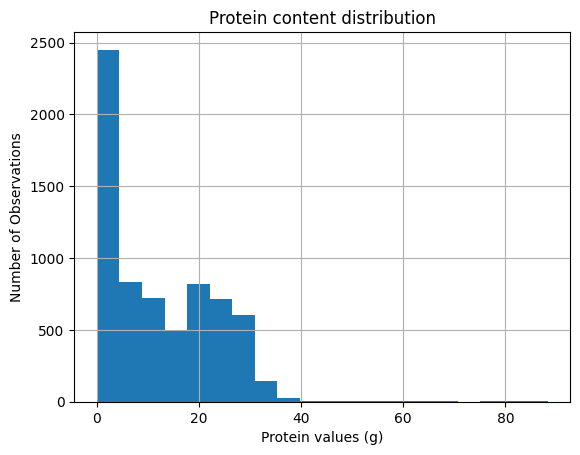

In [405]:
food['protein'].hist(bins=20)
plt.title('Protein content distribution')
plt.ylabel('Number of Observations')
plt.xlabel('Protein values (g)')
plt.show()

Once the data is negative skewed, in order to avaluate a high protein diet we may use the median of its value to subset the `food` data frame returning the foods that are most rich in protein

In [406]:
protein_rich = food[food['protein'] >= food['protein'].median()]
protein_rich.head()

fdc_id                                item  ... vitamin_c  main_ingredient
20  167532                  Bread, white wheat  ...       0.0            Bread
21  167533                       Bagels, wheat  ...       0.0           Bagels
48  167933  Crackers, whole-wheat, reduced fat  ...       0.0         Crackers
56  167941       Crackers, cheese, reduced fat  ...       0.0         Crackers
58  167943                       Bread, potato  ...       0.0            Bread

[5 rows x 13 columns]

Checking how the data is distributed on the `protein_rich` data frame in order to select the best central measure to adopt

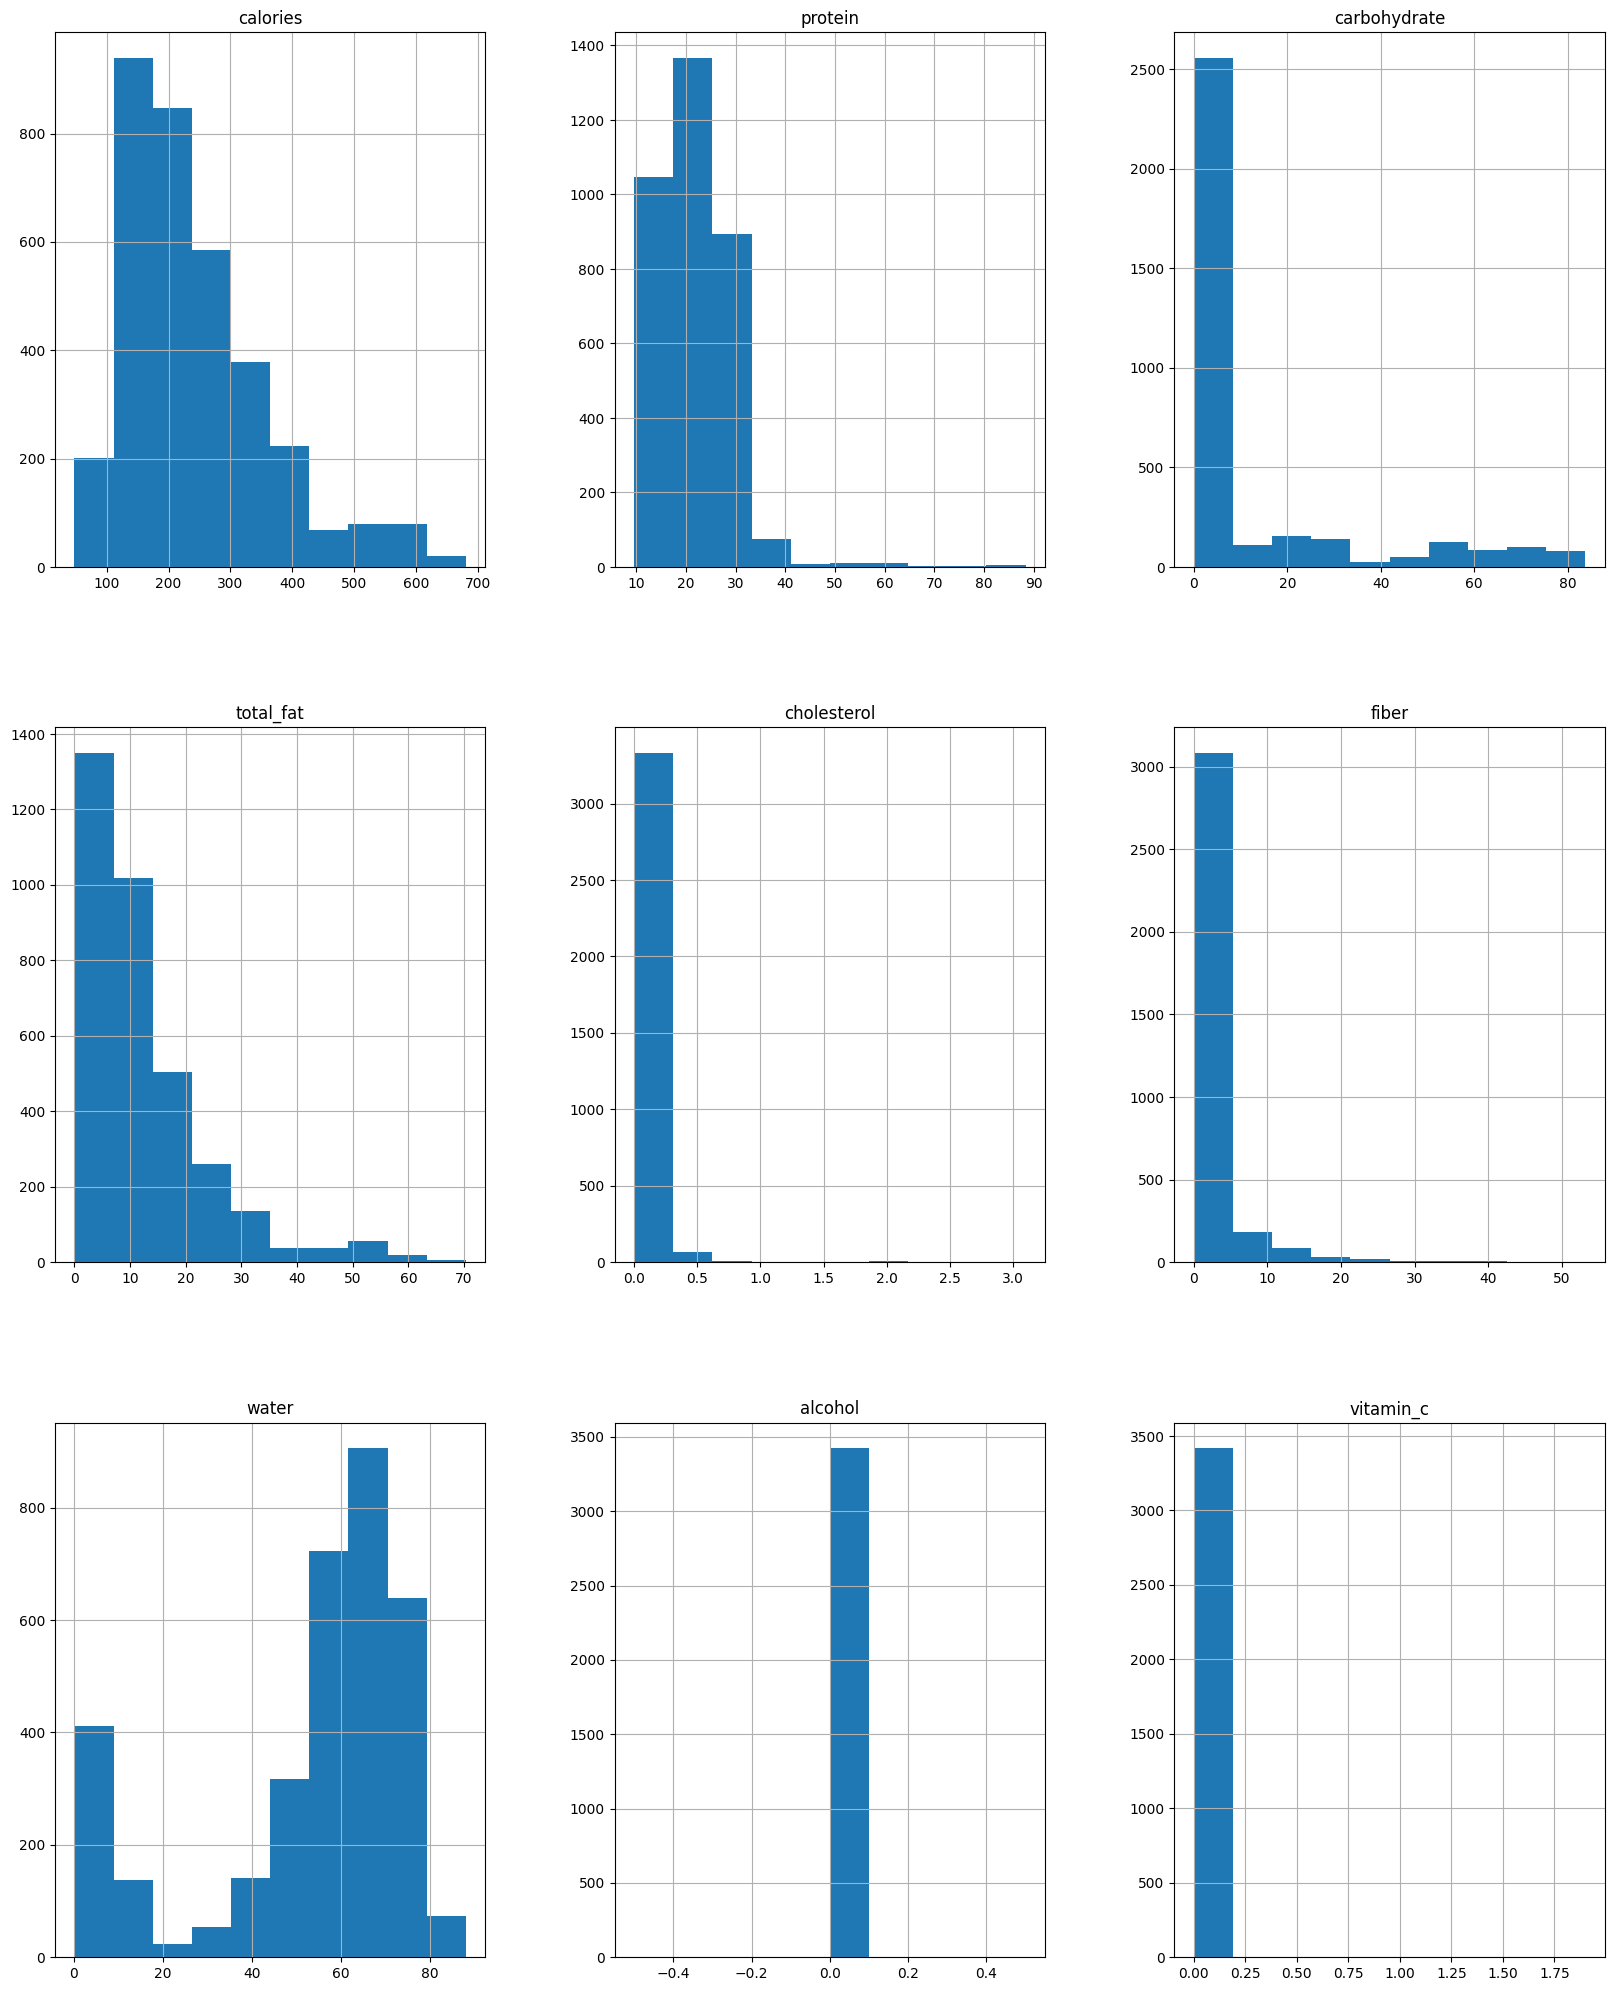

In [407]:
protein_rich.hist(figsize=(20,25))
plt.show()

As observed for the zero carb diet, the non-null data are skewed towards positive or negative. Hence, the median will be adopted once again as measure of central tendency

In [408]:
protein_rich_median = protein_rich.median()
protein_rich_median

calories        214.000
protein          21.290
carbohydrate      0.000
total_fat         9.100
cholesterol       0.069
fiber             0.000
water            60.930
alcohol           0.000
vitamin_c         0.000
dtype: float64

Selecting all non-null features despite the `calories`, once these will be assessed later

In [409]:
columns = ['protein',
          'total_fat',
          'cholesterol',
          'water']

Plotting a pie chart in order to check the percentage of each feature on a diet rich in protein

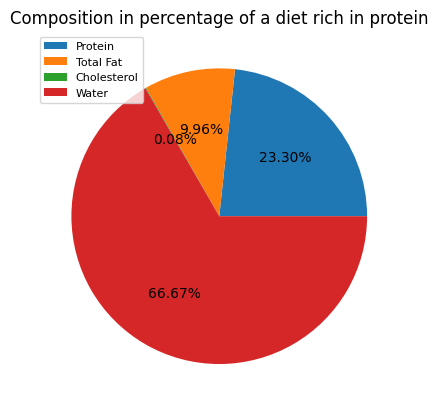

In [410]:
protein_rich_median[columns].plot(kind='pie',
                                  autopct='%.2f%%',
                                  labels=None)
plt.legend(['Protein','Total Fat','Cholesterol','Water'],
          fontsize=8)
plt.title('Composition in percentage of a diet rich in protein')
plt.show()

Focusing in the calories content and putting in evidence its distribution shape as well to observe for potential outliers a boxplot and a histogram were plotted

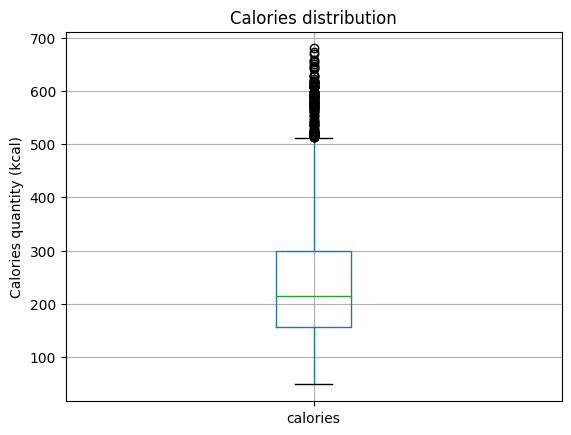

In [411]:
protein_rich.boxplot('calories')
plt.ylabel('Calories quantity (kcal)')
plt.title('Calories distribution')
plt.show()

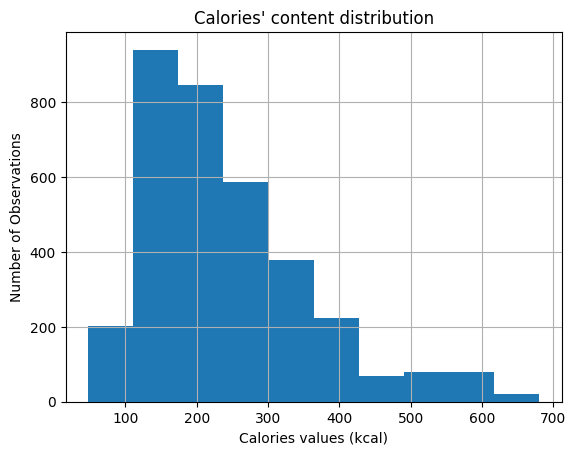

In [412]:
protein_rich.calories.hist()
plt.ylabel('Number of Observations')
plt.xlabel('Calories values (kcal)')
plt.title('Calories\' content distribution')
plt.show()

As observed above the calories' histogram is skewed, the, to evaluate the calories content on this diet the median will be employed

In [413]:
protein_rich.calories.median()

214.0

Conclusion:

1. **As observed through the analysis a diet rich in protein will be composed of, majorly, Water, followed by Protein, Total Fat and Cholesterol**
2. **The diet will consist of around 214 kcal**

## 4) Protein, carbohydrates and fat kcal/g: does it correspond to approximations done by Cleveland Clinic? 

### 4.1) Protein

Creating the LinearRegression instance and assigning it to `model`

In [414]:
model = LinearRegression()

Partitioning the data frame columns `protein` and `calories` in order to create test and train data

In [415]:
protein = food['protein'].to_numpy().reshape(-1,1)

protein_train, protein_test, calories_train, calories_test = train_test_split(protein,
                                                                              food['calories'],
                                                                              test_size=0.3,
                                                                              random_state=42)

Fitting the model using the training variables

In [416]:
model.fit(protein_train,calories_train)

LinearRegression()

Making predictions about the test data

In [417]:
calories_predicted = model.predict(protein_test)
calories_predicted

array([239.68478224, 233.71028459, 220.65225081, ..., 202.99707364,
       207.36167671, 234.92664938])

Plotting the regression plot

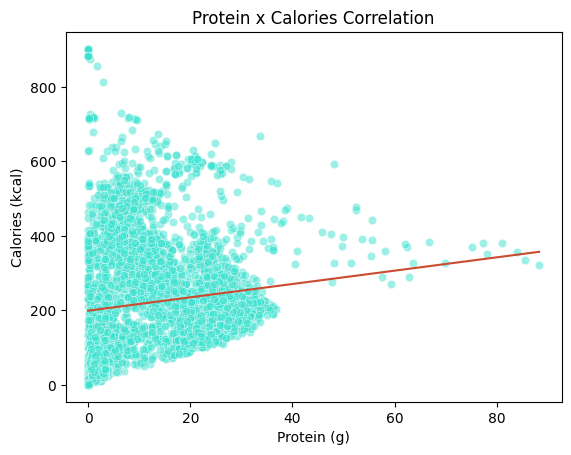

In [418]:
sns.scatterplot(x=protein_train.ravel(),
                y=calories_train,
                alpha=0.5,
                color='#3ce2d0')

sns.lineplot(x=protein_test.ravel(),
             y=calories_predicted,
             color='#ca4b2f')

plt.title('Protein x Calories Correlation')
plt.ylabel('Calories (kcal)')
plt.xlabel('Protein (g)')
plt.show()

Observing the R square, linear and angular coefficients of the regression prediction

In [419]:
r_square = model.score(protein_test,calories_predicted)
intercept = model.intercept_
angular_coeff = model.coef_

metrics = {'r_square':r_square,
           'intercept':intercept,
           'angular_coeff':angular_coeff}

for metric,value in metrics.items():
    print(f'{metric} = {value}')

r_square = 1.0
intercept = 199.36586698471677
angular_coeff = [1.78877175]


The R square has the value of 1 which is means a perfect linear correlation between the two variables

The line equation therefore is **calories (kcal) = 199.3659 + 1.7888 protein (100 g)**

Some disagreements with the estimative given by the Cleveland Clinic were observed. 1 g of protein, according to this linear regression model, is equivalente to approximately 200 kcal. According to the former the correct value of 1 g of protein is 4 kcal

### 4.2) Carbohydrates

Following the same steps as done to the proteins, the regression for the `carbohydrates` feature results on the subsequent results

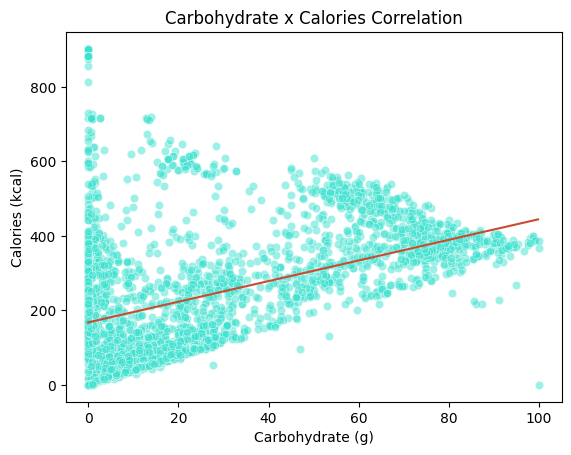

In [420]:
carb = food['carbohydrate'].to_numpy().reshape(-1,1)
model = LinearRegression()
carb_train, carb_test, calories_train, calories_test = train_test_split(carb,
                                                                        food['calories'],
                                                                        test_size=0.3,
                                                                        random_state=42)
model.fit(carb_train,calories_train)
calories_predicted = model.predict(carb_test)

sns.scatterplot(x=carb_train.ravel(),
                y=calories_train,
                color='#3ce2d0',
                alpha=0.5)

sns.lineplot(x=carb_test.ravel(),
             y=calories_predicted,
             color='#ca4b2f')
plt.title('Carbohydrate x Calories Correlation')
plt.xlabel('Carbohydrate (g)')
plt.ylabel('Calories (kcal)')
plt.show()

In [421]:
r_square = model.score(carb_test,calories_predicted)
intercept = model.intercept_
angular_coeff = model.coef_

metrics = {'r_square':r_square,
           'intercept':intercept,
           'angular_coeff':angular_coeff}

for metric,value in metrics.items():
    print(f'{metric} = {value}')

r_square = 1.0
intercept = 167.87052141638753
angular_coeff = [2.77139098]


The R square has the value of 1 which is means a perfect linear correlation between the two variables

The line equation therefore is **calories (kcal) = 167.9705 + 2.7714 carbohydrate (100 g)**

Some disagreements with the estimative given by the Cleveland Clinic were observed. 1 g of carbohydrate, according to this linear regression model, is equivalente to approximately 200 kcal. According to the former the correct value of 1 g of carbohydrate is 4 kcal

### 4.3) Fat

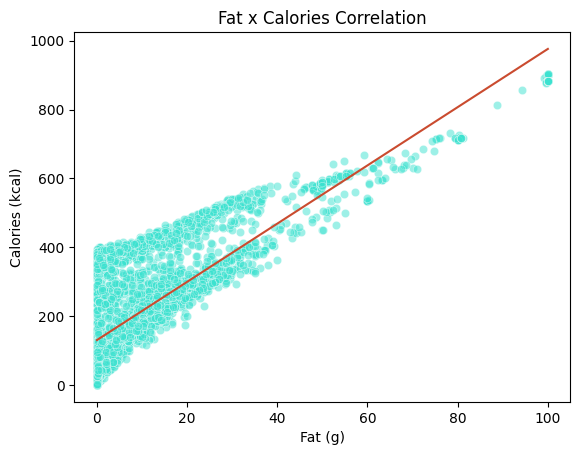

In [422]:
fat = food['total_fat'].to_numpy().reshape(-1,1)
model = LinearRegression()
fat_train, fat_test, calories_train, calories_test = train_test_split(fat,
                                                                      food['calories'],
                                                                      test_size=0.3,
                                                                      random_state=42)
model.fit(fat_train,calories_train)
calories_predicted = model.predict(fat_test)

sns.scatterplot(x=fat_train.ravel(),
                y=calories_train,
                color='#3ce2d0',
                alpha=0.5)

sns.lineplot(x=fat_test.ravel(),
             y=calories_predicted,
             color='#ca4b2f')
plt.title('Fat x Calories Correlation')
plt.xlabel('Fat (g)')
plt.ylabel('Calories (kcal)')
plt.show()

In [423]:
r_square = model.score(fat_test,calories_predicted)
intercept = model.intercept_
angular_coeff = model.coef_

metrics = {'r_square':r_square,
           'intercept':intercept,
           'angular_coeff':angular_coeff}

for metric,value in metrics.items():
    print(f'{metric} = {value}')

r_square = 1.0
intercept = 130.29252954940642
angular_coeff = [8.45908371]


The R square has the value of 1 which is means a perfect linear correlation between the two variables

The line equation therefore is **calories (kcal) = 130.2926 + 8.4591 fat (100 g)**

Some disagreements with the estimative given by the Cleveland Clinic were observed. 1 g of fat, according to this linear regression model, is equivalente to approximately 200 kcal. According to the former the correct value of 1 g of fat is 4 kcal

The error must be associated with the fact that the nutritional information is based on 100 g of each food product, leading to incorrect conclusions. Therefore, in order to correct this we will transform the nutritional info from the `food` data frame to a portion of 1 g

In [424]:
food = food[['total_fat','carbohydrate','protein','calories']] / 100
food.head()

total_fat  carbohydrate  protein  calories
1     0.1127        0.5342   0.0434      3.30
4     0.0922        0.4105   0.0658      2.73
5     0.0949        0.4839   0.0742      3.09
6     0.0940        0.4416   0.0692      2.89
8     0.2483        0.6430   0.0510      5.01

## 5) Adjusting the linear regression

### 5.1) Protein

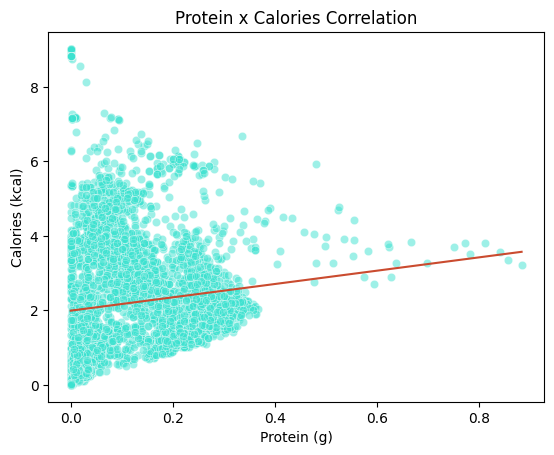

In [425]:
protein = food['protein'].to_numpy().reshape(-1,1)
model = LinearRegression()
protein_train, protein_test, calories_train, calories_test = train_test_split(protein,
                                                                              food['calories'],
                                                                              test_size=0.3,
                                                                              random_state=42)
model.fit(protein_train,calories_train)
calories_predicted = model.predict(protein_test)

sns.scatterplot(x=protein_train.ravel(),
                y=calories_train,
                alpha=0.5,
                color='#3ce2d0')

sns.lineplot(x=protein_test.ravel(),
             y=calories_predicted,
             color='#ca4b2f')

plt.title('Protein x Calories Correlation')
plt.ylabel('Calories (kcal)')
plt.xlabel('Protein (g)')
plt.show()

In [426]:
r_square = model.score(protein_test,calories_predicted)
intercept = model.intercept_
angular_coeff = model.coef_

metrics = {'r_square':r_square,
           'intercept':intercept,
           'angular_coeff':angular_coeff}

for metric,value in metrics.items():
    print(f'{metric} = {value}')

r_square = 1.0
intercept = 1.9936586698471674
angular_coeff = [1.78877175]


The R square has the value of 1 which is means a perfect linear correlation between the two variables

The line equation therefore is **calories (kcal) = 1.9937 + 1.7888 protein (per g)**

**Now, after the adjust, we may conclude that the model is in agreement with the Cleveland Clinic once a gram of protein is nearly 3.8 kcal, having then a deviation of 0.2 kcal to the estimate made by the clinic**

Determining the error relative to the prediction made by the Cleveland Clinic

In [434]:
error = ((3.8 - 4.0) / 4.0) * 100
print(f'The error of the measure in percentage was {error:.2f}%')

The error of the measure in percentage was -5.00%


### 5.2) Fat

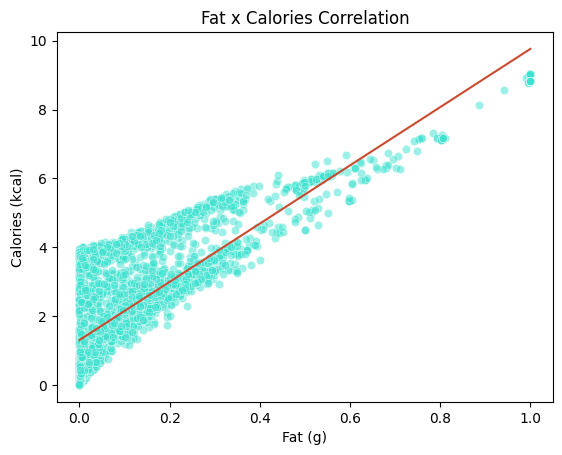

In [428]:
fat = food['total_fat'].to_numpy().reshape(-1,1)
model = LinearRegression()
fat_train, fat_test, calories_train, calories_test = train_test_split(fat,
                                                                              food['calories'],
                                                                              test_size=0.3,
                                                                              random_state=42)
model.fit(fat_train,calories_train)
calories_predicted = model.predict(fat_test)

sns.scatterplot(x=fat_train.ravel(),
                y=calories_train,
                alpha=0.5,
                color='#3ce2d0')

sns.lineplot(x=fat_test.ravel(),
             y=calories_predicted,
             color='#ca4b2f')

plt.title('Fat x Calories Correlation')
plt.ylabel('Calories (kcal)')
plt.xlabel('Fat (g)')
plt.show()

In [429]:
r_square = model.score(fat_test,calories_predicted)
intercept = model.intercept_
angular_coeff = model.coef_

metrics = {'r_square':r_square,
           'intercept':intercept,
           'angular_coeff':angular_coeff}

for metric,value in metrics.items():
    print(f'{metric} = {value}')

r_square = 1.0
intercept = 1.302925295494064
angular_coeff = [8.45908371]


The R square has the value of 1 which is means a perfect linear correlation between the two variables

The line equation therefore is **calories (kcal) = 1.3030 + 8.4591 fat (per g)**

**Now, after the adjust, we may conclude that the model is in agreement with the Cleveland Clinic once a gram of fat is nearly 9.8 kcal, having then a deviation of 0.8 kcal to the estimate made by the clinic**

Determining the error relative to the prediction made by the Cleveland Clinic

In [430]:
error = ((9.8 - 9.0) / 9.0) * 100
print(f'The error of the measure in percentage was {error:.2f}%')

The error of the measure in percentage was 8.89%


### 5.3) Carbohydrate

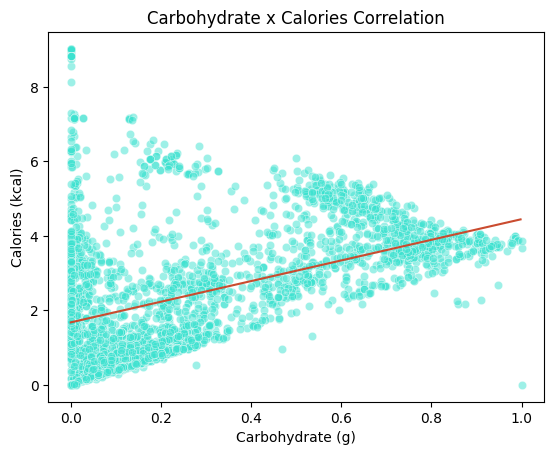

In [431]:
carb = food['carbohydrate'].to_numpy().reshape(-1,1)
model = LinearRegression()
carb_train, carb_test, calories_train, calories_test = train_test_split(carb,
                                                                              food['calories'],
                                                                              test_size=0.3,
                                                                              random_state=42)
model.fit(carb_train,calories_train)
calories_predicted = model.predict(carb_test)

sns.scatterplot(x=carb_train.ravel(),
                y=calories_train,
                alpha=0.5,
                color='#3ce2d0')

sns.lineplot(x=carb_test.ravel(),
             y=calories_predicted,
             color='#ca4b2f')

plt.title('Carbohydrate x Calories Correlation')
plt.ylabel('Calories (kcal)')
plt.xlabel('Carbohydrate (g)')
plt.show()

In [432]:
r_square = model.score(carb_test,calories_predicted)
intercept = model.intercept_
angular_coeff = model.coef_

metrics = {'r_square':r_square,
           'intercept':intercept,
           'angular_coeff':angular_coeff}

for metric,value in metrics.items():
    print(f'{metric} = {value}')

r_square = 1.0
intercept = 1.6787052141638754
angular_coeff = [2.77139098]


The R square has the value of 1 which is means a perfect linear correlation between the two variables

The line equation therefore is **calories (kcal) = 1.6787 + 2.7714 carbohydrate (per g)**

**Now, after the adjust, we may conclude that the model is in agreement with the Cleveland Clinic once a gram of fat is nearly 4,5 kcal, having then a deviation of 0.5 kcal to the estimate made by the clinic**

Determining the error relative to the prediction made by the Cleveland Clinic

In [433]:
error = ((4.5 - 4.0) / 4.0) * 100
print(f'The error of the measure in percentage was {error:.2f}%')

The error of the measure in percentage was 12.5%


# Summarizing

- The richest fruit in Vitamin C is Acerola
- The correlation between the water content and calories is highly negative, therefore, food rich in water are poor on calories and vice-versa
- A zero-carb diet will be mostly composed of water, protein, fat and cholesterol
- A diet rich in protein will be majorly composed of water, protein, fat and cholesterol
- With the adjusted linear regression model a proper relation between calories and nutrients (carbohydrate, protein and fat) has been achieved having a minor deviation in relation to the estimative made by the Cleveland Clinic 